# Jupyter Notebooks Example - Controlling Test Equipment using Tango Device Proxies 

This notebook provides an example on how to use Jupyter Notebooks to interact with different test equipment Tango devices in the ITF Low. Here we aim to send a signal from the AWG (arbitrary waveform generator) through to the spectrum analyser via several other pieces of test equipment.

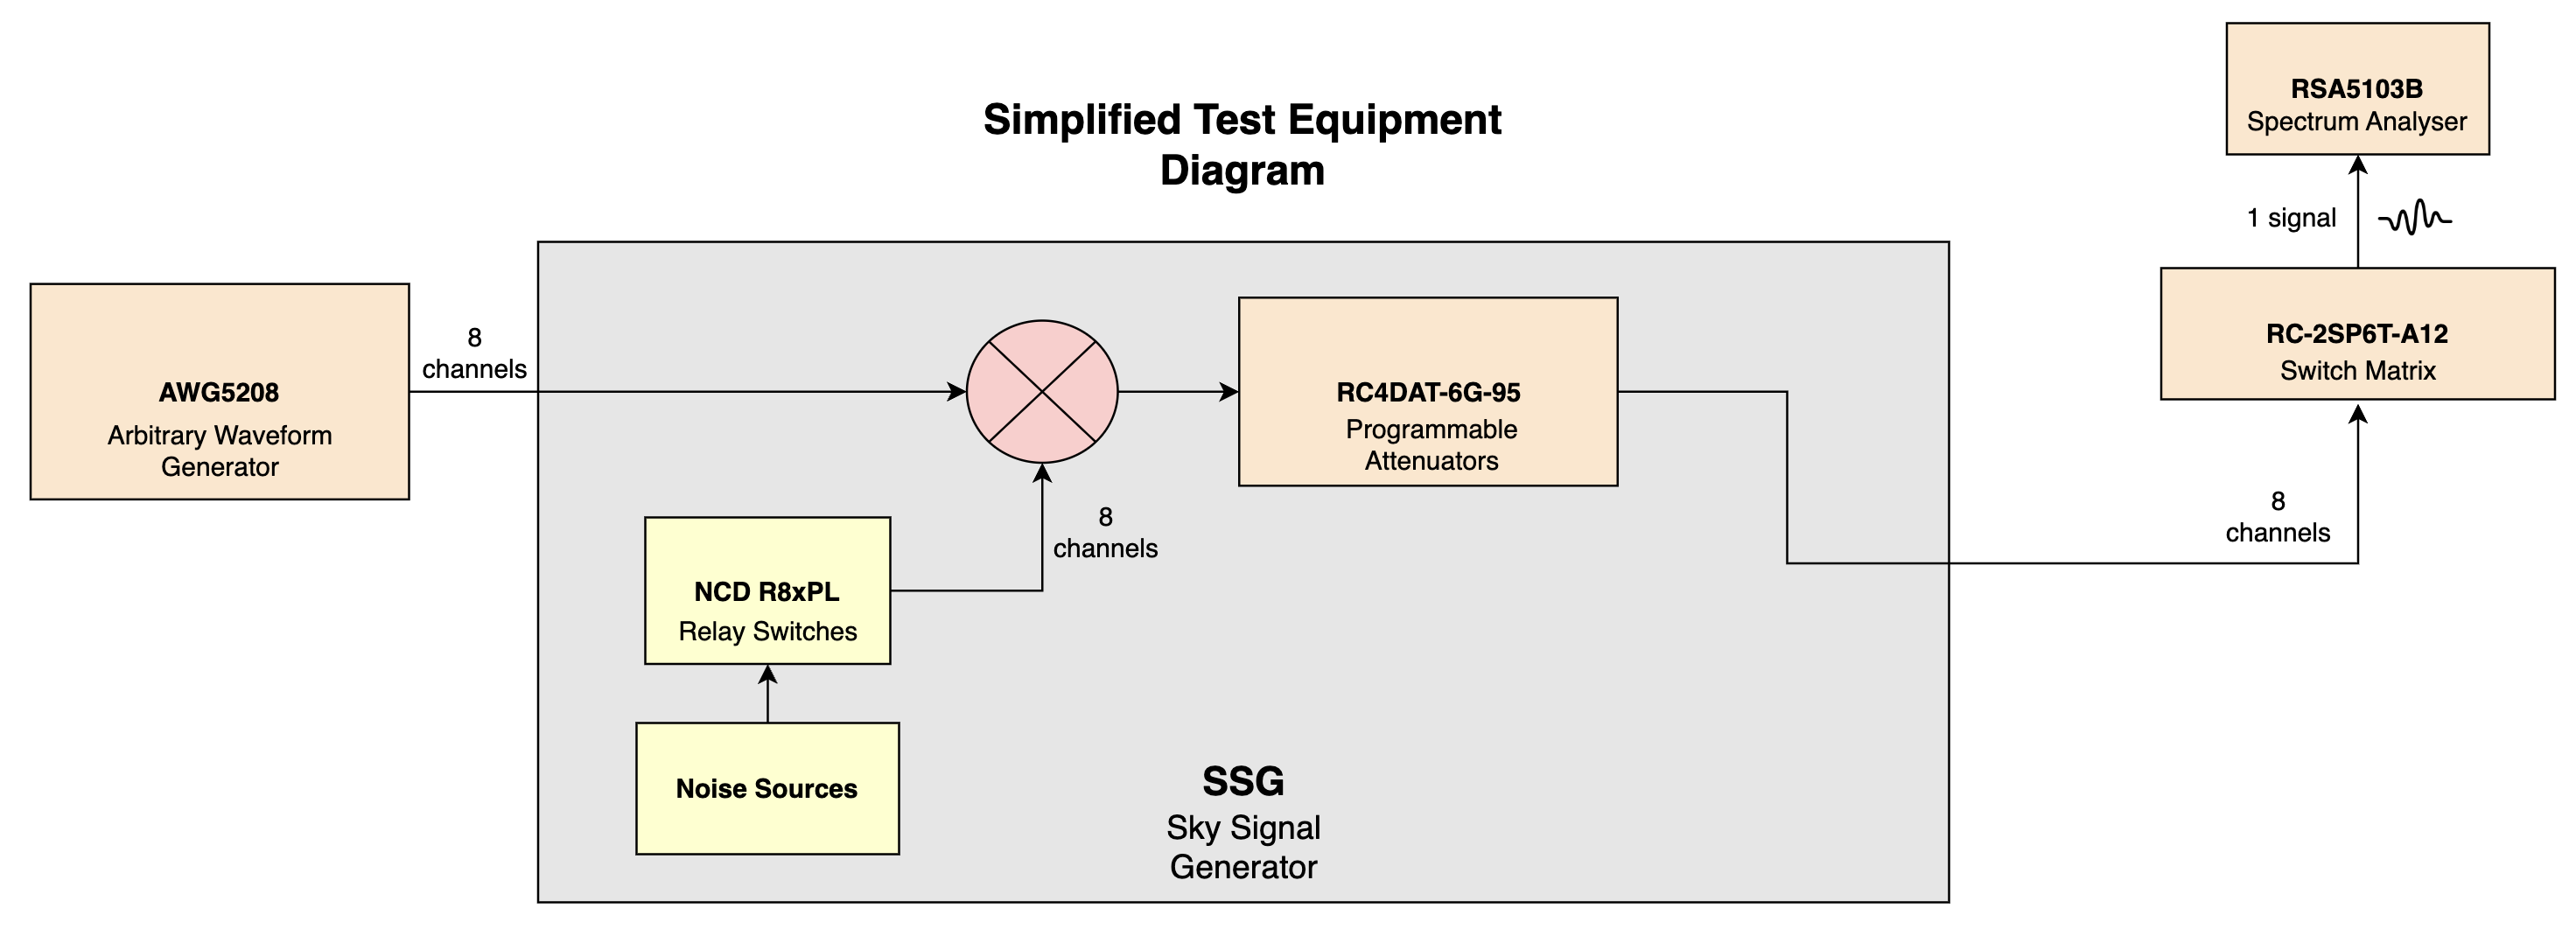

### A Brief Introduction to Tango Test Equipment Devices

The SKA project heavily relies on Tango for its control systems. This is a free open source device-oriented controls toolkit for controlling any kind of hardware or software. As a result, we have created Tango devices for test equipment instruments in the ITF to provide the necessary monitoring and control. Currently, all Tango supported test equipment devices are deployed on the ITF Kubernetes cluster as pods. We can think of these "pods" as deployable units of computing. For us here, these pods contain the software written for each specific device which fits the tango framework.

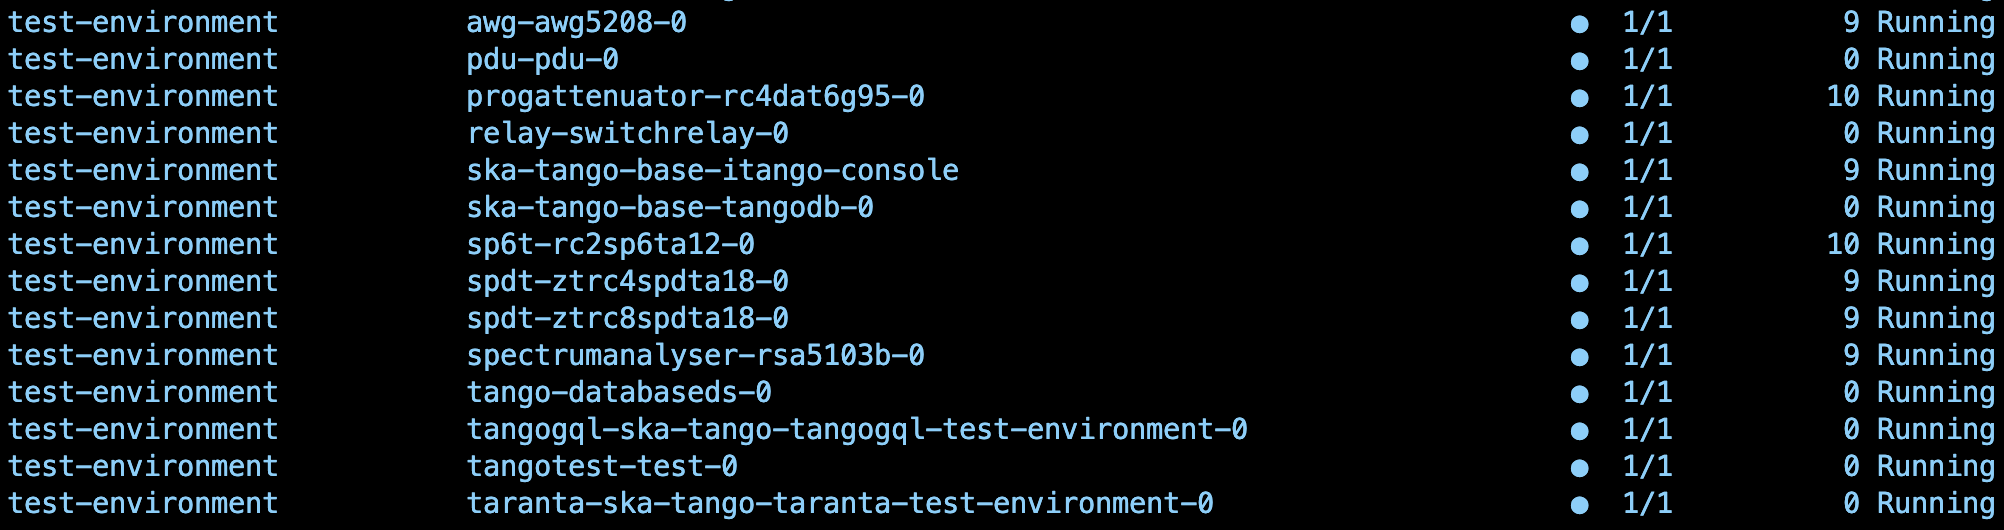


The key to how these software devices interface with the hardware is defined by tango ```attributes```. For most of these equipment, SCPI is the common standard used for syntax and commands to use in controlling programmable test and measurement devices. An example of an attribute specification can be seen below and demonstrates how relevant SCPI commands are exposed to the tango test equipment devices. Please note how each ```attribute``` contains a ```field``` which details the relevant commands and queries for that attribute.

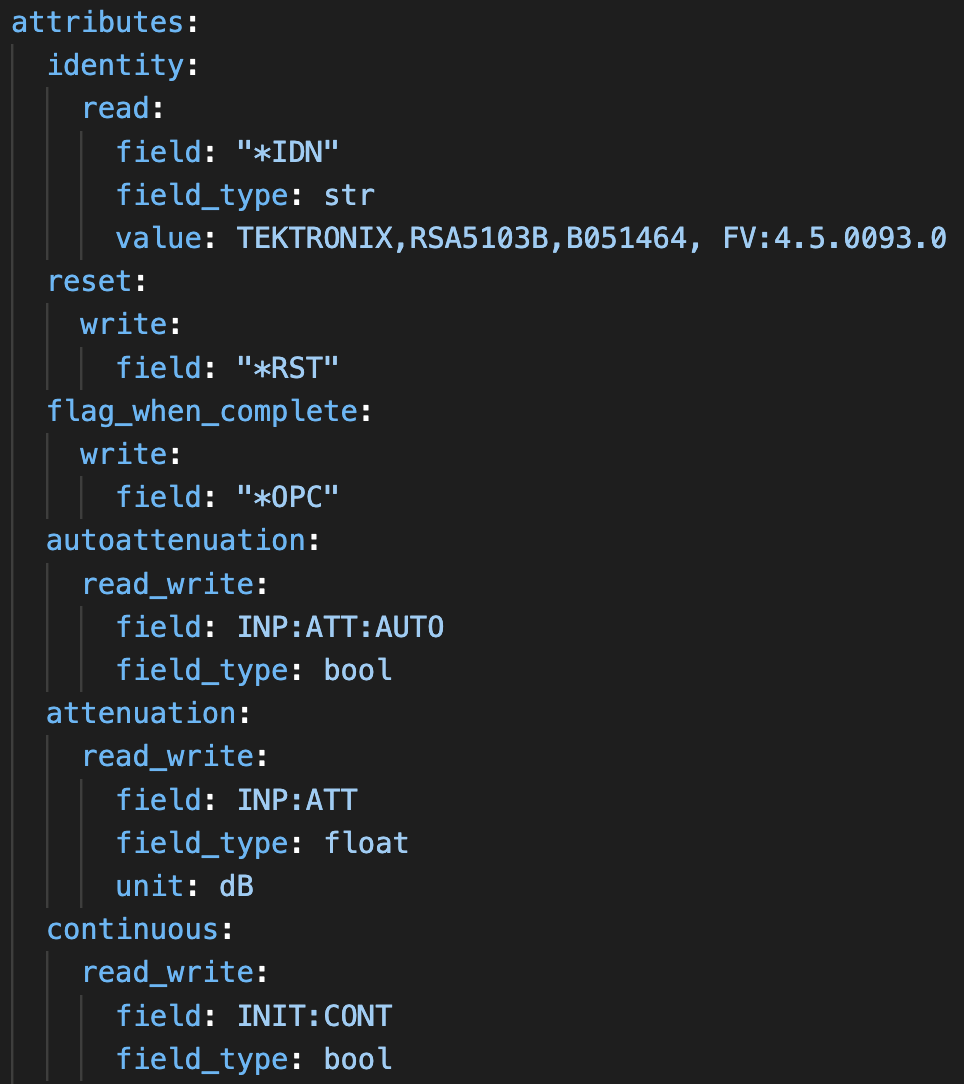



### Configuration Capture

Here we use some of the configuration capture tools to display the states of the ITF cluster. Below we display the chart dependencies, pods and tango configuration involved with the deployment/s (```test-environment``` and ```sut```)

In [1]:
import configuration  # # Python packages for configuration capture on the cluster
import display

charts = configuration.get_charts()
pods = configuration.get_pods()
tango_config = configuration.get_tango_config()

print("CHARTS")
display.as_json_tree(charts)
print("\nPODS")
display.as_json_tree(pods)
print("\nTANGO CONFIGURATION")
display.as_json_tree(tango_config)

CHARTS


<IPython.core.display.JSON object>


PODS


<IPython.core.display.JSON object>


TANGO CONFIGURATION


<IPython.core.display.JSON object>

### Capture start time

In [2]:
log_start = display.utc_now()
print(log_start)

2023-08-16T09:32:41.321Z


### Initialise Device Proxies

Here we define ```DeviceProxy``` objects to the Tango Devices running in the ITF cluster. These objects are what actually allow us to interact with the devices and send commands and queries to the hardware.

To turn these devices ```ON```, set the attribute ```adminMode = 0```.

In [3]:
awg = DeviceProxy("low-itf/awg/1")  # Arbritrary Waveform Generator (AWG5208)
progattenuator1 = DeviceProxy(
    "low-itf/progattenuator/1"
)  # Programmable Attenuator (RC4DAT-6G-95)
progattenuator2 = DeviceProxy("low-itf/progattenuator/2")
relay = DeviceProxy("low-itf/relay/1")
sp6t = DeviceProxy("low-itf/sp6t/1")  # Switch Matrix (RC-2SP6T-A18)
spectana = DeviceProxy("low-itf/spectana/1")  # Spectrum Analyser (RSA5103B)

In [4]:
awg.adminMode = 0
progattenuator1.adminMode = 0  # SSG has been taken down
progattenuator2.adminMode = 0  # SSG has been taken down
relay.adminMode = 0
sp6t.adminMode = 0
spectana.adminMode = 0  ## Socket server errors

In [5]:
# Display and check the device status
print(
    f"AWG: {awg.state().name}\nPROGATTENUATOR1: {progattenuator1.state().name}\nPROGATTENUATOR2: {progattenuator2.state().name}\nRELAY: {relay.state().name}\n2SP6T: {sp6t.state().name}\nSPECTANA: {spectana.state().name}"
)

AWG: ON
PROGATTENUATOR1: ON
PROGATTENUATOR2: ON
RELAY: ON
2SP6T: ON
SPECTANA: ON


### Produce sine waves on channels 1 of the AWG

The arbritrary waveform generator in the ITF is the input to the sky signal generator. This is the 

In [7]:
# Set up variable arguments
mode = "FGEN"
waveform = "SINE"
frequency_Hz = 300e6
power_dB = 0

In [8]:
# Set device attributes
awg.instrument_mode = mode
awg.channel1_type = waveform
awg.channel1_freq = frequency_Hz
awg.channel1_amplitude_power = power_dB

In [9]:
print(
    f"The characteristics on the waveform are as follows:\n\nMODE: {awg.instrument_mode}\nTYPE: {awg.channel1_type}\nFREQUENCY (Hz): {awg.channel1_freq}\nPOWER (dBm): {awg.channel1_amplitude_power}"
)

The characteristics on the waveform are as follows:

MODE: FGEN
TYPE: SINE
FREQUENCY (Hz): 300000000.0
POWER (dBm): 1.7763568394e-15


In [10]:
# Play the signal through the channel 1 output
awg.channel1_output_state = True
sp6t.switch_a = 1  # As configured in the ITF, switch A must be set to position 1 to connect the AWG to the RSA
awg.Play()

In [11]:
# Window to be captured
start_freq = 100e6
stop_freq = 600e6

spectana.frequency_start = 100e6
spectana.frequency_stop = 600e6

spectana.autoattenuation = False
spectana.attenuation = 0.0

### Acquire the signal on the RSA5103B

In [12]:
import numpy as np

x_ticks = np.linspace(start_freq, stop_freq, 2401)

Text(0, 0.5, 'Amplitude (dB)')

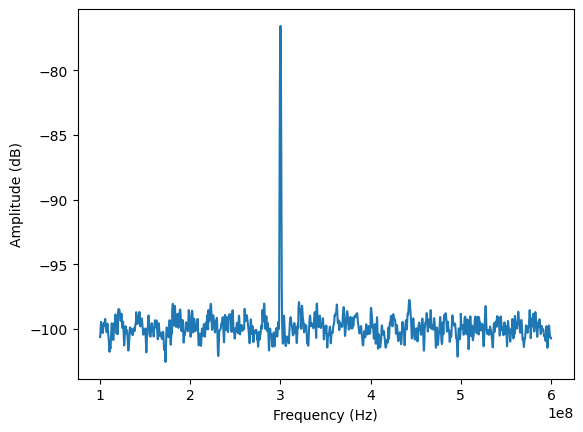

In [13]:
from matplotlib import pyplot as plt

plt.plot(x_ticks, spectana.trace1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")

### If we are ever unsure about what attributes are exposed...

In [ ]:
awg.get_attribute_list()

In [ ]:
spectana.get_attribute_list()

### Writing and Quering custom SCPI commands on Tango Devices

Our Tango devices support a range of SCPI commands which are represented as tango attributes. There may be instances in which our devices have not modelled a certain attribute needed for testing. In this case, we can use the ```Write()``` and ```Query()``` commands to send these raw SCPI messages through to the device.

For example, we will send the underlying SCPI command for the attribute ```marker_frequency```, and demonstrate that we obtain the same value as above.

In [14]:
#  Confirm the frequency of the signal that is being obtained on the spectrum analyser
spectana.findpeak()

In [15]:
spectana.marker_frequency

300000000.0

In [16]:
float(spectana.Query("CALC:SPEC:MARKER0:X"))

300000000.0

### Alter the signal chain

Set ```switch_a``` on the 2SP6T switch matrix to something other than position 1. This can be done by using the attribute ```switch_a```, or the ```Write()``` command in a Jupyter Notebook. We have also created a Taranta dashboard to support the testing activities in the ITF Low.

In [17]:
#  This process is currently not working as the SSG has been taken apart.
sp6t.Write("SP6TA:STATE:2")

Text(0, 0.5, 'Amplitude (dB)')

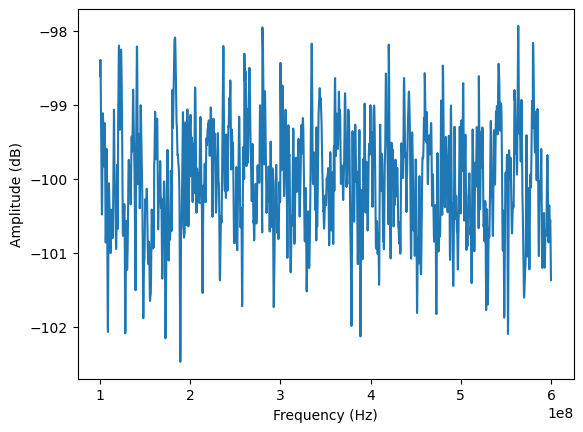

In [21]:
plt.plot(x_ticks, spectana.trace1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")

In [22]:
relay.Relay2 = True

In [23]:
plt.plot(x_ticks, spectana.trace1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")

Text(0, 0.5, 'Amplitude (dB)')

In [24]:
progattenuator1.channel_2 = 20.0

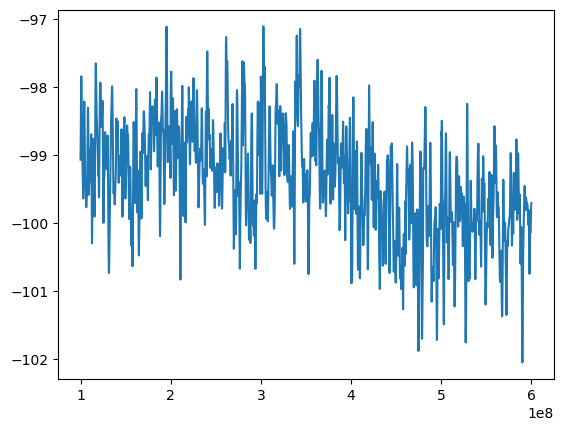

In [25]:
plt.plot(x_ticks, spectana.trace1)

### Shutdown steps

In [26]:
awg.Stop()
awg.channel1_output_state = False

In [27]:
awg.adminMode = 1
progattenuator1.adminMode = 1
progattenuator2.adminMode = 1
relay.adminMode = 1
sp6t.adminMode = 1
spectana.adminMode = 1

### Capture end time and link to logs

In [28]:
log_end = display.utc_now()
display.log_link(log_start, log_end)

## Execution logs
[Kibana: 2023-08-16T09:32:41.321Z to 2023-08-16T09:37:05.586Z](https://k8s.stfc.skao.int/kibana/app/logs/stream?logPosition=(start:'2023-08-16T09:32:41.321Z',end:'2023-08-16T09:37:05.586Z')&logFilter=(language:kuery,query:'ska.datacentre:%20"low-itf"%20and%20kubernetes.namespace:%20("sut"%20or%20"test-environment")%20and%20ska_severity:%20("INFO"%20or%20"WARNING"%20or%20"ERROR")'))

In [29]:
print("Some random change")

Some random change
